In [1]:
# We need PyTorch and GPyTorch
import torch
from torch import Tensor
import gpytorch
# Gaussian processes really don't work well without 64-bit precision
torch.set_default_dtype(torch.float64)
# For reproducibility:
torch.random.manual_seed(12345)
import sys
sys.path.append("..")

from norm_constrain import Norm2ConstrainedContainer_SE, Norm2ConstrainedContainer_rational, Norm2ConstrainedContainer_rational_cubic, Norm2ConstrainedContainer_ConvexCombination, Norm2ConstrainedContainer_KroneckerProduct

# And a few more players
import numpy as np
from scipy.integrate import dblquad
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
%matplotlib inline

In [2]:
# Import the data, check normalization, which should be \pi/2

with open('wgn.VMC_1.nucl.he4', 'r') as fd:
    lines = fd.readlines()
    
nk = 100 ; nr = 201
x = [] ; y = [] ; err = []
for line in lines[3:]:
    buf = line.split()
    x.append([float(buf[1]),float(buf[0])])
    y.append(float(buf[2]))
    err.append(float(buf[3]))
x = np.array(x) ; y = np.array(y) ; err = np.array(err)
xx = x.reshape((nr,nk,-1)) ; yy=y.reshape((nr,nk)) ; errr=err.reshape((nr,nk))

# The last 2 largest values of r contain an anomaly --- remove them
xx = xx[:-2,...] ; yy = yy[:-2,...] ; errr = errr[:-2,...]
nr = nr - 2

dr = xx[1,0,0] - xx[0,0,0] ; dk = xx[0,2,1] - xx[0,1,1] ; delta = np.array([dr, dk])

xxx = xx[1:,1:,:] - delta/2 # Cell centers
br = (yy[1:,1:] - yy[:-1,1:])/dr ; bk = (yy[1:,1:] - yy[1:,:-1])/dk
beta = np.array([br,bk]).transpose((1,2,0))

yyy = yy[1:,1:] - 0.5 * beta.dot(delta) # Interpolation to cell centers

ig = (yyy * xxx[:,:,0]**2 * xxx[:,:,1]**2).sum() *dk*dr *2 / np.pi
print("Integral / (pi/2) = %f"%ig)

Integral / (pi/2) = 1.006162


In [16]:
xx = torch.tensor(xx) ; yy = torch.tensor(yy) ; errr = torch.tensor(errr)
print(nr*nk)
# Subsample training data
subrate = 5 # per dimension, full subsampling rate is square of this
train_x = xx[::subrate,::subrate,:].reshape(-1,2)
train_y = yy[::subrate,::subrate].flatten()
train_err = errr[::subrate,::subrate].flatten()**2
print(train_x.shape)

# Test data is the remainder
idx_r, idx_k = torch.meshgrid(torch.arange(nr), torch.arange(nk))
idx = torch.stack((idx_r.flatten(), idx_k.flatten()), dim=-1)
idx = torch.logical_or(idx[:,0]%subrate != 0, idx[:,1]%subrate != 0)


test_x = xx.reshape((-1,2))[idx,:]
test_y = yy.flatten()[idx]
test_err = errr.flatten()[idx]**2
print(test_x.shape, test_y.shape, test_err.shape)

# Normalization value
nval = np.pi/2


19900
torch.Size([800, 2])
torch.Size([19100, 2]) torch.Size([19100]) torch.Size([19100])


/tmp/ipykernel_6063/3560153064.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(xx) ; yy = torch.tensor(yy) ; errr = torch.tensor(errr)


In [4]:
# 4-component model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nval):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.nm0_0 = Norm2ConstrainedContainer_SE()
        self.nm0_0.sigma = 2.0 ; self.nm0_0.gamma = 2.0; self.nm0_0.A = 5.0
        self.nm0_1 = Norm2ConstrainedContainer_SE(fix_amplitude=1.0)
        self.nm0_1.sigma = 1.0 ; self.nm0_1.gamma = 1.0
        kernels_0 = [self.nm0_0,self.nm0_1]
        self.nm0 = Norm2ConstrainedContainer_KroneckerProduct(kernels_0, norm_val=nval)

        self.nm1_0 = Norm2ConstrainedContainer_rational_cubic()
        self.nm1_0.alpha = 2.0 ; self.nm1_0.p = 2.5 ; self.nm1_0.A = 5.0
        self.nm1_1 = Norm2ConstrainedContainer_rational_cubic(fix_amplitude=1.0)
        self.nm1_1.alpha = 2.0 ; self.nm1_1.p = 2.5
        kernels_1 = [self.nm1_0,self.nm1_1]
        self.nm1 = Norm2ConstrainedContainer_KroneckerProduct(kernels_1, norm_val=nval)

        self.nm2_0 = Norm2ConstrainedContainer_SE()
        self.nm2_0.sigma = 2.0 ; self.nm2_0.gamma = 2.0 ; self.nm2_0.A = 5.0
        self.nm2_1 = Norm2ConstrainedContainer_rational_cubic(fix_amplitude=1.0)
        self.nm2_1.alpha = 2.0 ; self.nm2_1.p = 2.5
        kernels_2 = [self.nm2_0,self.nm2_1]
        self.nm2 = Norm2ConstrainedContainer_KroneckerProduct(kernels_2, norm_val=nval)
        
        self.nm3_0 = Norm2ConstrainedContainer_rational_cubic()
        self.nm3_0.alpha = 2.0 ; self.nm3_0.p = 2.5 ; self.nm3_0.A = 5.0
        self.nm3_1 = Norm2ConstrainedContainer_SE(fix_amplitude=1.0)
        self.nm3_1.sigma = 2.0 ; self.nm3_1.gamma = 2.0
        kernels_3 = [self.nm3_0,self.nm3_1]
        self.nm3 = Norm2ConstrainedContainer_KroneckerProduct(kernels_3, norm_val=nval)
        
        kernels = (self.nm0, self.nm1, self.nm2, self.nm3)
        # kernels = (self.nm0, self.nm1)

        self.mod = Norm2ConstrainedContainer_ConvexCombination(norm_val=nval, kernels=kernels)
        self.mod.compositions = torch.tensor([0.25, 0.25, 0.25])
        # self.mod.compositions = torch.tensor([0.5])
        
        self.covar_module = self.mod.covar_module
        self.mean_module = self.mod.mean_module

 
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_err)

model = GPRegressionModel(train_x, train_y, likelihood, nval)

/home/carlo/python_venvs/pytorch.venv/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


In [6]:
# Training
# training_iter = 1000

# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, train_y)
#     loss.backward()
#     print('Iter %d/%d - Loss: %.6f\nCompositions: %s\nSE_r: sigma: %.6f  gamma: %.6f  A: %.6f\nSE_k: sigma: %.6f  gamma: %.6f\nRat_r: alpha: %.6f  p: %.6f  A: %.6f\nRat_k: alpha: %.6f  p: %.6f\nSE_r: sigma: %.6f  gamma: %.6f  A: %.6f\nRat_k: alpha: %.6f  p: %.6f\nRat_r: alpha: %.6f  p: %.6f  A: %.6f\nSE_k: sigma: %.6f  gamma: %.6f' % (
#         i + 1, training_iter, loss.item(),
#         model.mod.full_compositions.tolist(),
#         model.nm0_0.sigma.item(),
#         model.nm0_0.gamma.item(),
#         model.nm0_0.A.item(),
#         model.nm0_1.sigma.item(),
#         model.nm0_1.gamma.item(),
#         model.nm1_0.alpha.item(),
#         model.nm1_0.p.item(),
#         model.nm1_0.A.item(),
#         model.nm1_1.alpha.item(),
#         model.nm1_1.p.item(),
#         model.nm2_0.sigma.item(),
#         model.nm2_0.gamma.item(),
#         model.nm2_0.A.item(),
#         model.nm2_1.alpha.item(),
#         model.nm2_1.p.item(),
#         model.nm3_0.alpha.item(),
#         model.nm3_0.p.item(),
#         model.nm3_0.A.item(),
#         model.nm3_1.sigma.item(),
#         model.nm3_1.gamma.item(),
#     ))
#     optimizer.step()
state_dict = torch.load("GP_Model_State.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
print("Final state:")
# print(''Iter %d/%d - Loss: %.6f')
print('Compositions: %s\nSE_r: sigma: %.6f  gamma: %.6f  A: %.6f\nSE_k: sigma: %.6f  gamma: %.6f\nRat_r: alpha: %.6f  p: %.6f  A: %.6f\nRat_k: alpha: %.6f  p: %.6f\nSE_r: sigma: %.6f  gamma: %.6f  A: %.6f\nRat_k: alpha: %.6f  p: %.6f\nRat_r: alpha: %.6f  p: %.6f  A: %.6f\nSE_k: sigma: %.6f  gamma: %.6f' % (
        # i + 1, training_iter, loss.item(),
        model.mod.full_compositions.tolist(),
        model.nm0_0.sigma.item(),
        model.nm0_0.gamma.item(),
        model.nm0_0.A.item(),
        model.nm0_1.sigma.item(),
        model.nm0_1.gamma.item(),
        model.nm1_0.alpha.item(),
        model.nm1_0.p.item(),
        model.nm1_0.A.item(),
        model.nm1_1.alpha.item(),
        model.nm1_1.p.item(),
        model.nm2_0.sigma.item(),
        model.nm2_0.gamma.item(),
        model.nm2_0.A.item(),
        model.nm2_1.alpha.item(),
        model.nm2_1.p.item(),
        model.nm3_0.alpha.item(),
        model.nm3_0.p.item(),
        model.nm3_0.A.item(),
        model.nm3_1.sigma.item(),
        model.nm3_1.gamma.item(),
    ))

torch.save(model.state_dict(), 'GP_Model_State.pth')

Final state:
Compositions: [0.220293234792308, 0.030205345317400198, 0.647857751393873, 0.10164366849641882]
SE_r: sigma: 3.341431  gamma: 2.581752  A: 11.593858
SE_k: sigma: 0.939521  gamma: 0.724854
Rat_r: alpha: 1.544230  p: 3.113974  A: 26.898030
Rat_k: alpha: 6.215887  p: 2.462844
SE_r: sigma: 1.736519  gamma: 1.753263  A: 45.577771
Rat_k: alpha: 1.803405  p: 3.460718
Rat_r: alpha: 2.235238  p: 3.391707  A: 28.396426
SE_k: sigma: 1.427701  gamma: 1.870650


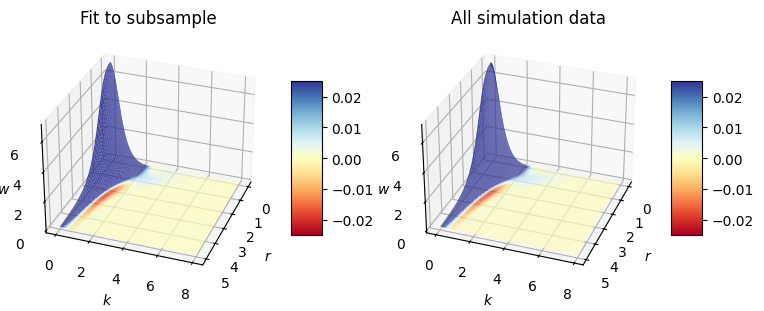

In [54]:
Np = 128
xmax = xx[-1,-1] * 1.01
locs = torch.linspace(0.0, 1.0, Np)
x_plot = locs.unsqueeze(-1) * xmax
Xr_plot, Xk_plot = torch.meshgrid(x_plot[:,0], x_plot[:,1], indexing="xy")
X_plot = torch.stack((Xr_plot.flatten(), Xk_plot.flatten()), dim=-1)

model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#    preds = likelihood(model(pred_x))
    plotted = model(X_plot)
Xr_np = Xr_plot.numpy() ; Xk_np = Xk_plot.numpy()
lower, upper = plotted.confidence_region() # 2-sigma cr
lower = lower.numpy().reshape((Np,Np)); upper = upper.numpy().reshape((Np,Np))
mn = plotted.mean.numpy().reshape((Np,Np))

fig = plt.figure()
fig.set_figheight(4) ; fig.set_figwidth(9)
ax = fig.add_subplot(1, 2, 1, projection='3d', azim=20)
ax.set_xlabel("$r$") ; ax.set_ylabel("$k$") ; ax.set_zlabel("$w$", labelpad=-4)
ax.set_title("Fit to subsample")

norm = colors.Normalize(vmin=-0.025, vmax=0.025, clip=True)
surf = ax.plot_surface(Xr_np, Xk_np, mn, cmap=cm.RdYlBu, norm=norm, rstride=1, cstride=1)
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)

Xr_in = xx[...,0].T ; Xk_in = xx[...,1].T ; wig = yy.T

ax = fig.add_subplot(1,2,2, projection='3d', azim=20)
ax.set_xlabel("$r$") ; ax.set_ylabel("$k$") ; ax.set_zlabel("$w$", labelpad=-4)

# norm = colors.Normalize(vmin=-0.025, vmax=0.025, clip=True)
norm = colors.Normalize(vmin=-0.025, vmax=0.025)
surf = ax.plot_surface(Xr_in, Xk_in, wig, cmap=cm.RdYlBu, norm=norm, rstride=1, cstride=1)
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("All simulation data")
plt.savefig("fit_4comps_He4.png", format="png")

In [19]:
# Test normalization integral of GP surrogate
def mkgrid(rl, rr, nr, kl, kr, nk):
    rbnds = torch.linspace(rl, rr, nr+1)
    kbnds = torch.linspace(kl, kr, nk+1)
    rctrs = 0.5 * (rbnds[:-1] + rbnds[1:] )
    kctrs = 0.5 * (kbnds[:-1] + kbnds[1:] )
    
    R, K = torch.meshgrid((rctrs,kctrs))
    grid = torch.stack((R.flatten(), K.flatten()), dim=-1)
    return grid

r1 = 4.0 ; r2 = 40.0 ; k1 = 3.0 ; k2 = 40.0
nr11 = 512 ; nk11 = 512
nr12 = 256 ; nk12 = 256
nr21 = 256 ; nk21 = 256
nr22 = 128 ; nk22 = 128
g11 = mkgrid(0, r1, nr11, 0, k1, nk11)
g12 = mkgrid(0, r1, nr12, k1, k2, nk12)
g21 = mkgrid(r1, r2, nr21, 0, k1, nk21)
g22 = mkgrid(r1, r2, nr22, k1, k2, nk22)
dv11 = (r1/nr11) * (k1/nk11)
dv12 = (r1/nr12) * ((k2-k1)/nk12)
dv21 = ((r2-r1)/nr21) * (k1/nk21)
dv22 = ((r2-r1)/nr22) *((k2-k1)/nk22)

with torch.no_grad(),  gpytorch.settings.skip_posterior_variances():
    pred11 = model(g11).mean
    print("11")
    pred12 = model(g12).mean
    print("12")
    pred21 = model(g21).mean
    print("21")
    pred22 = model(g22).mean
    print("22")
    
norm_int = (pred11 * g11[:,0]**2 * g11[:,1]**2).sum() * dv11 + \
           (pred12 * g12[:,0]**2 * g12[:,1]**2).sum() * dv12 + \
           (pred21 * g21[:,0]**2 * g21[:,1]**2).sum() * dv21 + \
           (pred22 * g22[:,0]**2 * g22[:,1]**2).sum() * dv22

norm_int = norm_int / nval
err = 1.0 - norm_int
print("Quadrature integral = %.9f ; Error = %8.3E" % (norm_int, err))

11
12
21
22
Quadrature integral = 0.999956533 ; Error = 4.347E-05


In [20]:
# Model validation
ntile_r = 20; ntile_k = 20
r_max = torch.max(xx[:,0]) * 1.01 ; k_max = torch.max(xx[:,1]) * 1.01
tbnd_r = torch.linspace(0.0, r_max, ntile_r+1)
tbnd_k = torch.linspace(0.0, k_max, ntile_k+1)

mses = np.zeros((ntile_r, ntile_k))
mses_norm = np.zeros((ntile_r, ntile_k))
chi2s_norm = np.zeros((ntile_r, ntile_k))

idx = torch.arange(len(test_y))
for itile_r in range(ntile_r):
    rl = tbnd_r[itile_r] ; rr = tbnd_r[itile_r+1]
    lind_r = torch.logical_and(test_x[:,0]>=rl, test_x[:,0]<rr)

    for itile_k in range(ntile_k):
        kl = tbnd_k[itile_k] ; kr = tbnd_k[itile_k+1]
        lind_k = torch.logical_and(test_x[:,1]>=kl, test_x[:,1]<kr)
        lind = torch.logical_and(lind_r, lind_k)
        
        tx = test_x[lind,:]
        ty = test_y[lind]
        te = test_err[lind]
        nsamp = len(ty)
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            mvn = model(tx)
            lik = likelihood(mvn, noise=te)
            mean, covar = lik.loc, lik.lazy_covariance_matrix
            covar = covar.evaluate_kernel()
            diff = (ty - mean).unsqueeze(-1)
            inv_quad = covar.inv_quad(inv_quad_rhs=diff)
        
        mse = torch.sqrt((diff**2).sum()/nsamp).detach().numpy()
        mse_norm = torch.sqrt((diff**2/te).sum()/nsamp).detach().numpy()
        mses[itile_r, itile_k] = mse
        mses_norm[itile_r, itile_k] = mse_norm
        chi2s_norm[itile_r, itile_k] = inv_quad.detach().numpy() / nsamp
        
            

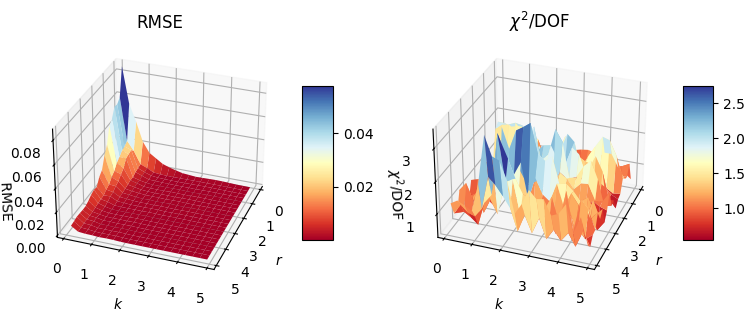

In [55]:
tctrs_r = 0.5*(tbnd_r[:-1] + tbnd_r[1:])
tctrs_k = 0.5*(tbnd_k[:-1] + tbnd_k[1:])
Tctrs_r, Tctrs_k = np.meshgrid(tctrs_r, tctrs_k, indexing='xy')


fig = plt.figure()
fig.set_figheight(4) ; fig.set_figwidth(9)
ax = fig.add_subplot(1, 2, 1, projection='3d', azim=20)
ax.set_xlabel("$r$") ; ax.set_ylabel("$k$") ; ax.set_zlabel("  RMSE", labelpad=0)
ax.set_title("RMSE")
surf = ax.plot_surface(Tctrs_r, Tctrs_k, mses.T, cmap=cm.RdYlBu, rstride=1, cstride=1)
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)


ax = fig.add_subplot(1,2,2, projection='3d', azim=20)
ax.set_xlabel("$r$") ; ax.set_ylabel("$k$") ; ax.set_zlabel("$\chi^2$/DOF", labelpad=-4)
ax.set_title("$\chi^2$/DOF")
surf = ax.plot_surface(Tctrs_r, Tctrs_k, chi2s_norm.T, cmap=cm.RdYlBu, rstride=1, cstride=1)
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig("validation_He4.png", format="png")


In [45]:
c2a = chi2s_norm.argmax()
c2a_r = c2a // ntile_k ; c2a_k = c2a % ntile_r
print(c2a, c2a_r, c2a_k)
print(chi2s_norm[c2a_r, c2a_k])
print(tctrs_r[c2a_r], tctrs_k[c2a_k])
print(Tctrs_r[c2a_r,c2a_k], Tctrs_k[c2a_r,c2a_k])
print(chi2s_norm[0,0])

385 19 5
3.511839607607722
tensor(4.8868) tensor(1.3783)
1.3783343750000001 4.886821875000001
0.8052819726238031
